In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from goertzel_test import sg_z
from peak_mark import pk_mark, pk_mark_block, peak_marking_block, dt_settings, dt_state

generating ./_goertzel.c
(already up-to-date)
the current directory is '/Users/nams/Documents/projects/gburg-ultrasonic'
running build_ext
building '_goertzel' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include/python3.8 -c _goertzel.c -o ./_goertzel.o
gcc -bundle -undefined dynamic_lookup -L/Users/nams/micromamba/envs/cq/lib -arch x86_64 -L/Users/nams/micromamba/envs/cq/lib -arch x86_64 -arch x86_64 ./_goertzel.o -lm -o ./_goertzel.cpython-38-darwin.so


In [3]:
dt = np.dtype([('counter', 'i4'), ('status', 'i4'), ('timestamp', 'f8'), ('micdata', '64i4')])
data = np.fromfile('mic_data/RawData_pureTX_Case1.dat',dtype=dt)
data = np.fromfile('mic_data/RawData_pureRX_330cm.dat',dtype=dt)
# data = np.fromfile('mic_data/RawData_pureTX_Case6.dat',dtype=dt)
# data = np.fromfile('mic_data/RawData_pureRX_330cm_Rev.dat',dtype=dt)


In [4]:
raw = np.zeros(64*len(data), dtype=np.int32)
for count in range(len(data)):
    raw[(count*64):((count+1)*64)] = data[count][3]

In [5]:
Z = {}
for k in range(98, 103):
    Z[k] = sg_z(raw>>14, k)

hamming = abs(Z[100] * 2.0 - Z[99] - Z[101])
y = abs(Z[100])

In [6]:
from peak_mark import pk_mark, pk_mark_block, peak_marking_block, dt_settings, dt_state

In [7]:
pks, s = pk_mark(y, 256, 2, 5e-4, 128, 300)
len(pks)

49

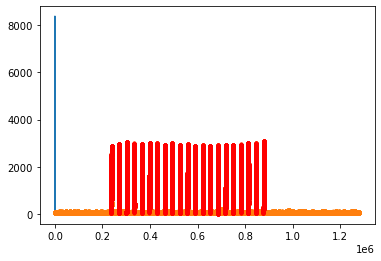

In [8]:
plt.figure()
t = np.arange(len(y))
plt.plot(t,y)
plt.plot(t[s==1], y[s==1],'.')
for pkinfo in pks:
    begin = int(pkinfo[0])
    end = int(pkinfo[0] + pkinfo[1])
    plt.plot(t[begin:end], y[begin:end], 'r.')

In [9]:
settings_np = np.recarray(1, dtype=dt_settings)[0]
state = np.recarray(1, dtype=dt_state)[0]

for repeat in range(10):
    settings_np.mph = 300
    settings_np.lag = 256
    settings_np.width = 128
    settings_np.threshold = 2
    settings_np.influence = 5e-4
    #print('settings', settings_np)

    state.avgFilter = 0
    state.std2 = 0
    state.write_addr = -1
    state.length = 0
    state.pk_idx = -1
    state.pk = -1
    state.time_between = -1
    state.pk_time = -1

    settings = settings_np

    pks_blocks = []
    signals = np.zeros(len(y))
    debug = np.zeros(len(y))
    filteredY = np.zeros(settings.lag)
    start = time.time()

    for count in range(len(y)//64):    
        packet = y[(count*64):((count+1)*64)]
        packet_s = signals[(count*64):((count+1)*64)]
        # packet_d = debug[(count*64):((count+1)*64)]
        result = peak_marking_block(packet, len(packet), filteredY, settings, state, packet_s)
        if result:
            pks_blocks.extend(result)
    print(time.time()-start)
print(state)
len(pks_blocks), len(y)

0.9375479221343994
0.1463329792022705
0.17566609382629395
0.14630889892578125
0.2713358402252197
0.17842984199523926
0.1588449478149414
0.14193987846374512
0.1685340404510498
0.14736294746398926
(40.3291016, 0.69078655, 1279999, 401096, 0, -1, -1., 401045)


(49, 1280000)

In [10]:
np.array(pks)[:,-1] - np.array(pks_blocks)[:,-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
np.array(pks)[:,1] - np.array(pks_blocks)[:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
np.diff(np.array(pks)[:,-2]) - np.array(pks_blocks)[1:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
import scipy.constants as codata

In [17]:
codata.h * codata.c / 1.5e-6 * ((4e-4)**0.5)

2.6485944761985717e-21